In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import sklearn.metrics

import time
import tqdm
import torch

from torch.utils.data import DataLoader

%run models/models.ipynb

plt.style.use('dark_background')

### Datasets

In [2]:
class AssetDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, chunk_size, dataset_size, scheme=None, normalize=False, shuffle=False):
        
        # Scheme
        
        default_scheme = {'initial_asset_price': 
                              {'binary': True,
                               'encoding_format': '>f', 
                               'bits_count': 32,
                               'factor': 1,
                               'target_column': False},
                          'volatility': 
                              {'binary': True,
                               'encoding_format': 'i1', 
                               'bits_count': 8,
                               'factor': 100,
                               'target_column': False},
                          'asset_price':
                              {'binary': True,
                               'encoding_format': '>f', 
                               'bits_count': 32,
                               'factor': 1,
                               'target_column': False},
                          'probability':
                              {'binary': False,
                               'factor': 1,
                               'target_column': True}}                       
        
        self.scheme = scheme or default_scheme
                   
        target_column, target_parameters = next((column, parameters)
                                                for column, parameters in self.scheme.items()
                                                if parameters['target_column'])        
           
        # Parameters
        
        fields_count = 0
        data_dtype = 'i1'

        target_flags = []
        
        for column, parameters in self.scheme.items():
            
            if parameters['binary']:                 
                column_size = parameters['bits_count']
                
            else:
                data_dtype = float
                column_size = 1
            
            fields_count += column_size
            
            target_flags_for_column = [parameters['target_column']] * column_size
            
            target_flags.extend(target_flags_for_column)
            
        self.target_flags_vector = np.array(target_flags)
        
        
        # Shuffle maps
        
        self.shuffle = shuffle
        
        if shuffle:

            self.shuffle_maps = dict()
            self.unshuffle_maps = dict()
            
            for column, parameters in self.scheme.items():

                encoding_format = parameters.get('encoding_format')
                bits_count = parameters.get('bits_count')

                if encoding_format:

                    to_positions = np.arange(bits_count, dtype='i1')

                    np.random.shuffle(to_positions)

                    shuffle_map = np.empty(bits_count, dtype='i1')
                    unshuffle_map = np.empty(bits_count, dtype='i1')

                    for from_position, to_position in enumerate(to_positions):

                        shuffle_map[from_position] = to_position
                        unshuffle_map[to_position] = from_position

                    self.shuffle_maps[encoding_format] = shuffle_map
                    self.unshuffle_maps[encoding_format] = unshuffle_map            

            # print("self.shuffle_maps:", self.shuffle_maps)
            # print("self.unshuffle_maps:", self.unshuffle_maps)
        
        # Data

        chunks_count = dataset_size // chunk_size
        
        self.data = np.zeros(shape=(dataset_size, fields_count), dtype=data_dtype)
        self.not_encoded_data = np.zeros(shape=(dataset_size, len(self.scheme)), dtype=data_dtype)
        
        dataset_iterator = pd.read_csv(dataset_path, iterator=True, chunksize=chunk_size)
        
        chunk_tracker = tqdm.tqdm(range(chunks_count),
                                  desc=f"Loading",
                                  ncols=110,
                                  unit='chunk',
                                  total=chunks_count)                          
        # Loading
        
        row_offset = 0

        for chunk_index in chunk_tracker:
            
            chunk = next(dataset_iterator)

            column_offset = 0
            not_encoded_column_offset = 0

            for column_name, parameters in self.scheme.items():
                
                factor = parameters.get('factor', 1)
                
                conversion_function = parameters.get('conversion', lambda x: x)
                
                column_chunk = chunk[column_name]             
                
                if normalize:
                
                    column_chunk = column_chunk - column_chunk.mean()
                    
                    column_chunk = column_chunk / np.abs(column_chunk).max()
                    
                column_chunk = conversion_function(column_chunk * factor) 
                
                # print("column_name:", column_name)
                # print("column_chunk.mean():", column_chunk.mean())
                # print("normalized_column_chunk.mean():", normalized_column_chunk.mean())
                
#                 if column_name == 'probability':
                
#                     print("chunk[column_name]:", chunk[column_name])
#                     print("factor:", factor)
#                     print("conversion_function:", conversion_function)
#                     print("normalized_column_chunk:", normalized_column_chunk)
                
                if parameters['binary']:
                    column = self.encode_to_bits(column_chunk,
                                                 dtype=parameters['encoding_format'], 
                                                 bits_count=parameters['bits_count']) 
                    
                    column_size = parameters['bits_count']
                    
                else:                        
                    column = column_chunk.to_numpy().reshape(-1, 1)                        
                    column_size = 1             

                self.data[row_offset : row_offset + chunk_size, 
                          column_offset : column_offset + column_size] = column
                
                self.not_encoded_data[row_offset : 
                                      row_offset + chunk_size, 
                                      not_encoded_column_offset : 
                                      not_encoded_column_offset + 1] = column_chunk.to_numpy().reshape(-1, 1)                

                column_offset += column_size
                
                not_encoded_column_offset += 1

            row_offset += chunk_size
                
        self.fields = self.data[:, ~self.target_flags_vector].astype(int)
        self.targets = self.data[:, self.target_flags_vector]
        
        self.field_dimensions = np.max(self.fields, axis=0).astype(int) + 1
        
        self.field_dimensions[self.field_dimensions < 2] = 2
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.targets[index].squeeze()
        
        return fields, target
    

    def encode_to_bits(self, inputs, dtype='>f', bits_count=32):
    
        input_bytes = np.array([inputs], dtype=dtype)

        integer_view = input_bytes.view('uint8')

        bits_vector = np.unpackbits(integer_view)
        
        bits = bits_vector.reshape(-1, bits_count)
        
        if self.shuffle:
            
            # print("encode - bits before:", bits)

            shuffle_map = self.shuffle_maps[dtype]

            bits = bits[:, shuffle_map]

            # print("encode - bits after:", bits)
            
        # print("input_bytes:", input_bytes)
        # print("integer_view:", integer_view)
        # print("bits_vector:", bits_vector)        
        # print("bits:", bits)
        
        return bits
    

    def decode_from_bits(self, bits, dtype='>f', bitorder='big'):
        
        if self.shuffle:

            # print("decode - bits before:", bits)

            unshuffle_map = self.unshuffle_maps[dtype]

            bits = bits[unshuffle_map]

            # print("decode - bits after:", bits)
        

        bits_vector = bits.reshape(-1)

        integer_view = np.packbits(bits_vector, bitorder=bitorder)

        output = integer_view.view(dtype)

        return output

### Splitter

In [3]:
class SequentialValueSampler(torch.utils.data.Sampler):

    def __init__(self, values):
        self.values = values

    def __iter__(self):
        return iter(self.values)

    def __len__(self):
        return len(self.values)


class Splitter:
    
    def __init__(self, dataset, shuffle=True, 
                 train_rate=0.8, valid_rate=0.1, 
                 batch_size=2048, dataloader_workers_count=8):
        
        self.dataset = dataset
                    
        dataset_length = len(dataset)

        train_length = int(dataset_length * train_rate)
        valid_length = int(dataset_length * valid_rate)

        test_length = dataset_length - train_length - valid_length
        
        self.lengths = (train_length, valid_length, test_length)

        dataset_indices = np.arange(dataset_length, dtype=int)
        
        if shuffle:        
            np.random.shuffle(dataset_indices)
        
        index_ranges = np.split(dataset_indices, (train_length,
                                                  train_length + valid_length))     
            
        train_sampler, valid_sampler, test_sampler = map(SequentialValueSampler, index_ranges)

        self.train_data_loader = DataLoader(dataset,
                                            batch_size=batch_size,
                                            sampler=train_sampler,
                                            num_workers=dataloader_workers_count)
        
        self.valid_data_loader = DataLoader(dataset,                                  
                                            batch_size=batch_size,
                                            sampler=valid_sampler,
                                            num_workers=dataloader_workers_count)
        
        self.test_data_loader = DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=test_sampler,
                                           num_workers=dataloader_workers_count)   

### Trainer

In [4]:
class Trainer:

    def __init__(self, splitter,
                 learning_rate=0.001, weight_decay=1e-6,
                 embedding_dimensions=16,
                 model=None, criterion=None, metric=None, optimizer=None,
                 device='cpu', batch_logging_interval=100):

        %run models/models.ipynb 
        
        field_dimensions = splitter.dataset.field_dimensions
        
        if model is None:

            model = CustomFactorizationMachine(field_dimensions, 
                                               embedding_dimensions=embedding_dimensions)
        
        if criterion is None:

            criterion = torch.nn.MSELoss()
            
        if metric is None:

            metric = sklearn.metrics.r2_score

        optimizer = torch.optim.Adam(params=model.parameters(), 
                                     lr=learning_rate, 
                                     weight_decay=weight_decay)
        
        self.device = torch.device(device)
        
        self.model = model.to(device)
        self.criterion = criterion
        self.metric = metric
        self.optimizer = optimizer
        self.splitter = splitter
        
        self.batch_logging_interval = batch_logging_interval
        
        self.train_data_loader = self.splitter.train_data_loader
        self.valid_data_loader = self.splitter.valid_data_loader
        self.test_data_loader = self.splitter.test_data_loader
        
        self.epoch_losses = []
        self.losses_per_epoch = []
        
        # TODO: EarlyStopper
    
    
    def fit(self, epochs=10):
        
        epoch_offset = len(self.epoch_losses)
        
        for epoch in range(epochs):
            
            epoch_start_time = time.time()
            
            train_batch_tracker = tqdm.tqdm(
                self.train_data_loader,
                desc=f"Epoch: {epoch_offset + epoch + 1}/{epoch_offset + epochs}",
                unit=' batches',
                ncols=110,
                mininterval=1,
            )            
            
            self.train(train_batch_tracker)
            
            epoch_loss, _ = self.test(self.valid_data_loader)
            
            self.epoch_losses.append(epoch_loss)
            
            epoch_duration = time.time() - epoch_start_time
            
            print(f"Validation {self.metric.__name__}: {epoch_loss:.05f}, "
                  f"Duration: {epoch_duration:.02f} seconds") 
            
        total_score, total_predictions = self.test(self.test_data_loader)
        
        # self.predictions = total_predictions
        
        print(f"\nTotal - Test {self.metric.__name__}: {total_score:.010f}")
    
    
    def train(self, train_batch_tracker):

        self.model.train()

        total_loss = 0
        
        losses = []

        for batch, (fields, target) in enumerate(train_batch_tracker):
            
            predictions = self.model(fields)
            
            loss = self.criterion(predictions, target.float())
            
            self.model.zero_grad()

            loss.backward()

            self.optimizer.step()

            total_loss += loss.item()

            if not (batch + 1) % self.batch_logging_interval:

                loss = total_loss / self.batch_logging_interval

                train_batch_tracker.set_postfix(loss=f"{loss:1.05f}")
                
                losses.append(loss)

                total_loss = 0
                
        self.losses_per_epoch.append(losses)
                
                
    def test(self, data_loader):
        
        self.model.eval()
    
        targets = []
        predictions = []

        with torch.no_grad():

            for fields, target in data_loader:

                prediction = self.model(fields)

                targets.extend(target.tolist())
                predictions.extend(prediction.tolist())

        score = self.metric(targets, predictions)
        
        return score, predictions
    


    def predict(self, indices):   
        
        encoded_fields = self.splitter.dataset.fields[indices]
        targets = self.splitter.dataset.targets[indices]

        self.model.eval()

        with torch.no_grad():

            predictions = self.model(torch.tensor(encoded_fields))
            
        # print("encoded_fields:", encoded_fields)
        # print("not_encoded_data:", self.splitter.dataset.not_encoded_data[indices])
        
        return targets, predictions

### 10) 15 Dataset

In [387]:
# Load Data

DATASET_PATH = 'simulated_prices/15_dataset.csv'

# DATASET_PATH = 'simulated_prices/alex_dataset.csv'

# DATASET_PATH = 'simulated_prices/multi_modal_dataset.csv'


DATASET_SIZE = 50000 * 2
# DATASET_SIZE = 4

ENCODE = True
# ENCODE = False

SHUFFLE = True

NORMALIZE = False


scheme = {'initial_asset_price': 
              {'binary': ENCODE,
               'encoding_format': 'i1', 
               'bits_count': 8,
               'factor': 1,
               'target_column': False},
          'volatility': 
              {'binary': ENCODE,
               'encoding_format': 'i1', 
               'bits_count': 8,
               'factor': 10,
               'target_column': False},
          'asset_price':
              {'binary': ENCODE,
               'encoding_format': 'i1', 
               'bits_count': 8,
               # 'factor': 10,
               'conversion': lambda x: x * 10 + 3,
               'target_column': False},
          'probability':
              {'binary': False,
               'factor': 100000,
               
               # 'conversion': lambda x: x ** 2,               
               # 'conversion': lambda x: 1 / (x + 0.00001),               
               # 'conversion': lambda x: x ** (1 / 2),
               
               'target_column': True}
         }  

dataset = AssetDataset(
    DATASET_PATH, 
    chunk_size=DATASET_SIZE, 
    dataset_size=DATASET_SIZE,
    scheme=scheme,
    normalize=NORMALIZE,
    shuffle=SHUFFLE
)

splitter = Splitter(dataset, batch_size=100, dataloader_workers_count=8)

trainer = Trainer(splitter=splitter, embedding_dimensions=16)


print("Dataset field:", dataset.fields.shape)
print("Dataset targets:", dataset.targets.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions)

print("Splitter lengths:", splitter.lengths) 

Loading: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.43chunk/s]

Dataset field: (100000, 24)
Dataset targets: (100000, 1)
dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Splitter lengths: (80000, 10000, 10000)


In [390]:
trainer.fit(epochs=9)

Epoch: 2/10: 100%|█████████████████████████████████████| 800/800 [00:02<00:00, 347.82 batches/s, loss=0.04754]


Validation r2_score: 0.97526, Duration: 2.65 seconds


Epoch: 3/10: 100%|█████████████████████████████████████| 800/800 [00:02<00:00, 372.06 batches/s, loss=0.04528]


Validation r2_score: 0.97547, Duration: 2.48 seconds


Epoch: 4/10: 100%|█████████████████████████████████████| 800/800 [00:02<00:00, 361.81 batches/s, loss=0.04543]


Validation r2_score: 0.97523, Duration: 2.54 seconds


Epoch: 5/10: 100%|█████████████████████████████████████| 800/800 [00:02<00:00, 369.70 batches/s, loss=0.04552]


Validation r2_score: 0.97540, Duration: 2.49 seconds


Epoch: 6/10: 100%|█████████████████████████████████████| 800/800 [00:02<00:00, 358.06 batches/s, loss=0.04555]


Validation r2_score: 0.97539, Duration: 2.56 seconds


Epoch: 7/10: 100%|█████████████████████████████████████| 800/800 [00:02<00:00, 350.41 batches/s, loss=0.04555]


Validation r2_score: 0.97534, Duration: 2.61 seconds


Epoch: 8/10: 100%|█████████████████████████████████████| 800/800 [00:02<00:00, 354.58 batches/s, loss=0.04554]


Validation r2_score: 0.97529, Duration: 2.60 seconds


Epoch: 9/10: 100%|█████████████████████████████████████| 800/800 [00:02<00:00, 349.58 batches/s, loss=0.04553]


Validation r2_score: 0.97525, Duration: 2.63 seconds


Epoch: 10/10: 100%|████████████████████████████████████| 800/800 [00:02<00:00, 362.06 batches/s, loss=0.04551]


Validation r2_score: 0.97521, Duration: 2.55 seconds

Total - Test r2_score: 0.9756872439


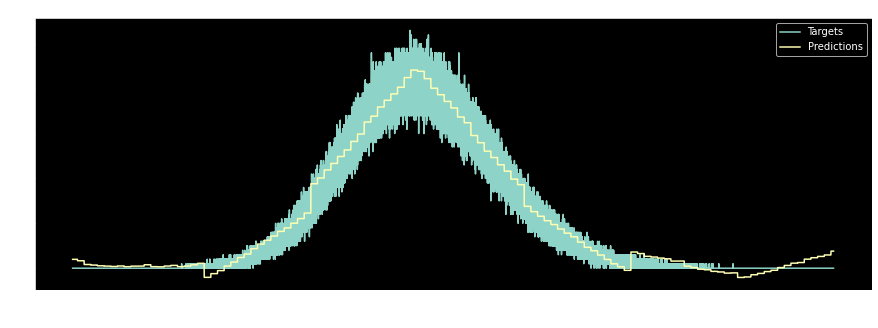

In [391]:
# Predict

indices = np.arange(0, len(dataset), 1)

targets, predictions = trainer.predict(indices)

probability_factor = scheme['probability']['factor']

defactored_targets = np.array(targets) / probability_factor
defactored_predictions = np.array(predictions) / probability_factor

# Plot

A = 0
B = A + 1000

figure = plt.gcf()
figure.set_size_inches(15, 5)

asset_prices = dataset.not_encoded_data[indices, 2]

plt.plot(asset_prices, defactored_targets, label=f"Targets")
plt.plot(asset_prices, defactored_predictions, label=f"Predictions")

# plt.plot(defactored_targets[A:B], label=f"Targets")
# plt.plot(defactored_predictions[A:B], label=f"Predictions")

plt.locator_params(axis='x', nbins=20)

plt.xlabel("Asset Price")
plt.ylabel("Probability")
plt.legend()

plt.show()

### 11) Critical Points

In [370]:
step_slice = slice(39189, 39191)

print("asset_prices:", asset_prices[step_slice])

# print("targets:", targets[step_slice].ravel())
print("predictions:", predictions[step_slice].numpy())

print("encoded:")
print(dataset.data[step_slice].astype(int))

asset_prices: [1152.4899  1152.51864]
predictions: [2.3406088 2.3406088]
encoded:
[[0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 3]
 [0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 2]]


In [121]:
step_slice = slice(42343, 42345)

print("asset_prices:", asset_prices[step_slice])

# print("targets:", targets[step_slice].ravel())
print("predictions:", predictions[step_slice].numpy())

print("encoded:")
print(dataset.data[step_slice].astype(int))

asset_prices: [1535991.5 1536003. ]
predictions: [3.9777868 3.8709311]
encoded:
[[0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0
  1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 4]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 3]]


In [122]:
step_slice = slice(51316, 51318)

print("asset_prices:", asset_prices[step_slice])

print("targets:", targets[step_slice].ravel())
print("predictions:", predictions[step_slice].numpy())

print("encoded:")
print(dataset.data[step_slice].astype(int))

asset_prices: [1638390.  1638401.4]
targets: [3.3 3.8]
predictions: [3.2222075 3.1254928]
encoded:
[[0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0
  1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 3]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]


In [109]:
step_slice = slice(47951, 47953)

print("asset_prices:", asset_prices[step_slice])

print("targets:", targets[step_slice].ravel())
print("predictions:", predictions[step_slice].numpy())

print("encoded:")
print(dataset.data[step_slice].astype(int))

asset_prices: [15.999891 16.000005]
targets: [4.  4.4]
predictions: [4.7931576 3.3072062]
encoded:
[[0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 0 0 0 1 1 1 0 4]
 [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 1 4]]


In [163]:
trainer.model.state_dict()['embedding.embedding.weight'].shape

torch.Size([48, 16])

In [24]:
# dataset.data

In [169]:
# dataset.not_encoded_data

In [ ]:
# # Save encoded dataset

# ENCODED_DATASET_PATH = 'simulated_prices/15_dataset_encoded.csv'

# columns = [f'initial_asset_price_bit_{i}' for i in range(32)]

# columns += [f'volatility_bit_{i}' for i in range(8)]

# columns += [f'asset_price_bit_{i}' for i in range(32)]

# columns += ['probability']

# encoded_dataset = pd.DataFrame(dataset.data, columns=columns)

# encoded_dataset.to_csv(ENCODED_DATASET_PATH, index=False)

In [ ]:
# plt.plot(trainer.epoch_losses[:], label=metric.__name__)

# plt.xlabel("Epoch")
# plt.ylabel(metric.__name__)
# plt.legend();

In [16]:
# a = np.array([14335.931, 14337.073])

# # a = np.array([1])

# b = dataset.encode_to_bits(a, dtype='>i4', bits_count=32)

# b

# c = dataset.decode_from_bits(b[1], dtype='>i4')

# c

In [ ]:
# a = np.array([10.527916 * 1000])

# b = dataset.encode_to_bits(a, dtype='>i4', bits_count=32)

# b

# a = np.array([10527.4353453455])

# b = dataset.encode_to_bits(a, dtype='>i4', bits_count=32)

# c = dataset.decode_from_bits(b, dtype='>i4')

# c

In [ ]:
# a = np.arange(32, dtype='int8')

# np.random.shuffle(a)


# to_positions = np.arange(32, dtype='int8')

# np.random.shuffle(to_positions)


# shuffle_map = np.empty(32, dtype='i1')
# unshuffle_map = np.empty(32, dtype='i1')

# for from_position, to_position in enumerate(to_positions):
    
#     shuffle_map[from_position] = to_position
#     unshuffle_map[to_position] = from_position

# shuffle_map, unshuffle_map

# b = a[shuffle_map]

# c = b[unshuffle_map]

# a, c

In [ ]:
# def decode_row(self, encoded_row):

#     decoded_fields = []
#     decoded_targets = []

#     field_offset = 0

#     for column_name, parameters in self.scheme.items():

#         if parameters['binary']:
#             column_size = parameters['bits_count']                
#         else:
#             column_size = 1

#         column = encoded_row[field_offset : field_offset + column_size]

#         if parameters['binary']:

#             decoded_column = self.decode_from_bits(column.astype(int),
#                                                    dtype=parameters['encoding_format']).item()

#         else:                
#             decoded_column = column.item()

#         if parameters['target_column']:

#             decoded_targets.append(decoded_column)

#         else:                
#             decoded_fields.append(decoded_column)

#         field_offset += column_size

#     return decoded_fields, decoded_targets

### 9) Alex Dataset

In [6]:
# Load Data

ASSET_DATASET_PATH = 'simulated_prices/alex_dataset.csv'

scheme = {'initial_asset_price': 
              {'binary': True,
               'encoding_format': '>f', 
               'bits_count': 32,
               'factor': 1,
               'target_column': False},
          'volatility': 
              {'binary': True,
               'encoding_format': 'i1', 
               'bits_count': 8,
               'factor': 100,
               'target_column': False},
          'asset_price':
              {'binary': True,
               'encoding_format': '>f', 
               'bits_count': 32,
               'factor': 1,
               'target_column': False},
          'probability':
              {'binary': False,
               'factor': 1000,
               
               # 'conversion': lambda x: x ** 2,               
               # 'conversion': lambda x: 1 / (x + 0.00001),               
               # 'conversion': lambda x: x ** (1 / 2),
               
               'target_column': True}
         }  

dataset = AssetDataset(
    ASSET_DATASET_PATH, 
    chunk_size=1000, 
    dataset_size=1000,
    scheme=scheme,
    # normalize=True
)

field_dimensions = dataset.field_dimensions

print("dataset.fields.shape:", dataset.fields.shape)
print("dataset.targets.shape:", dataset.targets.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions.sum())    

Loading: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 338.69chunk/s]

dataset.fields.shape: (1000, 72)
dataset.targets.shape: (1000, 1)
dataset.field_dimensions: 144


In [7]:
splitter = Splitter(dataset, batch_size=100, dataloader_workers_count=8)

metric = sklearn.metrics.r2_score

trainer = Trainer(splitter=splitter, embedding_dimensions=144, metric=metric)

In [26]:
trainer.fit(epochs=1)

Epoch: 23/23: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 56.88 batches/s]


Validation r2_score: 0.71919, Duration: 0.22 seconds

Total - Test r2_score: 0.6149587782


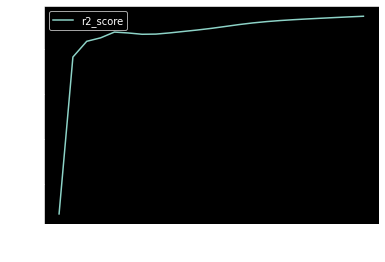

In [27]:
plt.plot(trainer.epoch_losses[:], label=metric.__name__)

plt.xlabel("Epoch")
plt.ylabel(metric.__name__)
plt.legend();

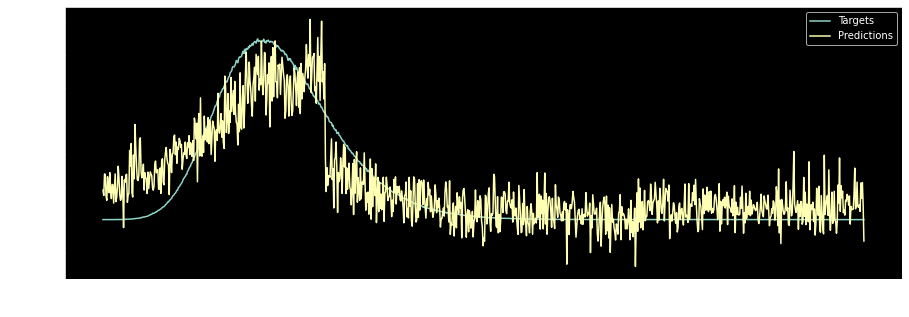

In [31]:
# Predict

indices = np.arange(0, len(dataset), 1)

targets, predictions = trainer.predict(indices)

probability_factor = scheme['probability']['factor']

defactored_targets = np.array(targets) / probability_factor
defactored_predictions = np.array(predictions) / probability_factor

# Plot

figure = plt.gcf()
figure.set_size_inches(15, 5)

asset_prices = dataset.not_encoded_data[indices, 2]

plt.plot(asset_prices, defactored_targets, label=f"Targets")
plt.plot(asset_prices, defactored_predictions, label=f"Predictions")

plt.locator_params(axis='x', nbins=20)

plt.xlabel("Asset Price")
plt.ylabel("Probability")
plt.legend()

plt.show()

In [268]:
# # Save

# MODEL_PATH = 'saved_models/alex_no_linear_model.pt'
# PREDICTIONS_PATH = 'predictions/alex_no_linear_predictions.xlsx'

MODEL_PATH = 'saved_models/alex_model.pt'
PREDICTIONS_PATH = 'predictions/alex_predictions.xlsx'

# torch.save(trainer.model.state_dict(), MODEL_PATH)

predictions_dataframe = pd.DataFrame({'Targets': defactored_targets, 'Predictions': defactored_predictions})

# predictions_dataframe.to_excel(PREDICTIONS_PATH, index=False)

# trainer.model.state_dict()

# predictions_dataframe

### 8) Assets - 10K Dataset

In [22]:
# Load Data

ASSET_DATASET_PATH = 'simulated_prices/asset_prices_10K.csv'

# ASSET_DATASET_PATH = 'simulated_prices/assets_no_probabilities_1M_samples.csv'


scheme = {'initial_asset_price': 
              {'binary': True,
               'encoding_format': '>f', 
               'bits_count': 32,
               'factor': 1,
               'target_column': False},
          'volatility': 
              {'binary': True,
               'encoding_format': 'i1', 
               'bits_count': 8,
               'factor': 100,
               'target_column': False},
          'asset_price':
              {'binary': True,
               'encoding_format': '>f', 
               'bits_count': 32,
               'factor': 1,
               'target_column': False},
          'probability':
              {'binary': False,
               'factor': 1000,
               
               # 'conversion': lambda x: x ** 2,               
               # 'conversion': lambda x: 1 / (x + 0.00001),               
               # 'conversion': lambda x: x ** (1 / 2),
               
               'target_column': True}
         }  

dataset = AssetDataset(
    ASSET_DATASET_PATH, 
    chunk_size=10000, 
    dataset_size=10000,
    scheme=scheme,
    normalize=True
)

field_dimensions = dataset.field_dimensions

print("dataset.fields.shape:", dataset.fields.shape)
print("dataset.targets.shape:", dataset.target.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions.sum())    

Loading: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.30chunk/s]

dataset.fields.shape: (10000, 72)
dataset.targets.shape: (10000, 1)
dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 144


In [23]:
dataset.target.mean()

-5.229594535194337e-15

In [24]:
splitter = Splitter(dataset, batch_size=100, dataloader_workers_count=8)

# metric = sklearn.metrics.mean_squared_error
metric = sklearn.metrics.r2_score

trainer = Trainer(splitter=splitter, embedding_dimensions=144, metric=metric)

Split 10000: (8000, 1000, 1000)


In [32]:
trainer.fit(epochs=10)

Epoch: 31/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 106.24 batches/s, loss=14968.64746]


Validation r2_score: 0.50167, Duration: 0.87 seconds


Epoch: 32/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 108.02 batches/s, loss=14870.01465]


Validation r2_score: 0.50321, Duration: 0.86 seconds


Epoch: 33/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 111.58 batches/s, loss=14775.20605]


Validation r2_score: 0.50464, Duration: 0.84 seconds


Epoch: 34/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 107.91 batches/s, loss=14684.06348]


Validation r2_score: 0.50599, Duration: 0.85 seconds


Epoch: 35/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 109.12 batches/s, loss=14596.44922]


Validation r2_score: 0.50725, Duration: 0.85 seconds


Epoch: 36/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 106.37 batches/s, loss=14512.21973]


Validation r2_score: 0.50843, Duration: 0.87 seconds


Epoch: 37/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 106.25 batches/s, loss=14431.25391]


Validation r2_score: 0.50955, Duration: 0.87 seconds


Epoch: 38/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 108.63 batches/s, loss=14353.41992]


Validation r2_score: 0.51061, Duration: 0.85 seconds


Epoch: 39/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 107.04 batches/s, loss=14278.59277]


Validation r2_score: 0.51162, Duration: 0.87 seconds


Epoch: 40/40: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 107.78 batches/s, loss=14206.64746]


Validation r2_score: 0.51258, Duration: 0.86 seconds

Total - Test r2_score: 0.4941015303


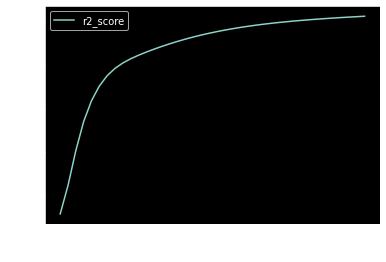

In [39]:
plt.plot(trainer.epoch_losses[:], label=metric.__name__)

plt.xlabel("Epoch")
plt.ylabel(metric.__name__)
plt.legend();

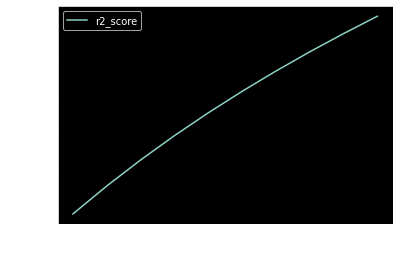

In [40]:
plt.plot(trainer.epoch_losses[-10:], label=metric.__name__)
    
plt.xlabel("Epoch")
plt.ylabel(metric.__name__)
plt.legend();

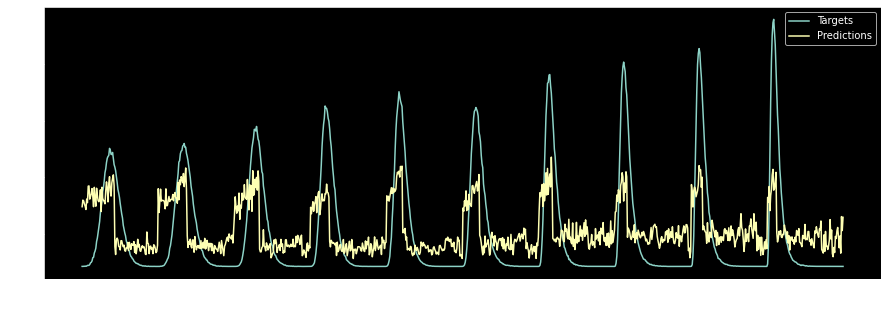

In [45]:
# Predict

indices = list(range(1000))
   
targets, predictions = zip(*map(trainer.predict_by_index, indices))

probability_factor = scheme['probability']['factor']

defactored_targets = np.array(targets) / probability_factor
defactored_predictions = np.array(predictions) / probability_factor

# Plot

figure = plt.gcf()
figure.set_size_inches(15, 5)

plt.plot(defactored_targets, label=f"Targets")
plt.plot(defactored_predictions, label=f"Predictions");

plt.xlabel("Sample Number")
plt.ylabel("Probability")
plt.legend()

plt.show()

In [ ]:
# Save

MODEL_PATH = 'saved_models/fm_assets_10K_144_embeddings_normalized.pt'
PREDICTIONS_PATH = 'predictions/10k_predictions_normalized.xlsx'

# torch.save(trainer.model.state_dict(), MODEL_PATH)

# trainer.model.state_dict()

predictions_dataframe = pd.DataFrame({'Targets': defactored_targets, 'Predictions': defactored_predictions})

# predictions_dataframe.to_excel(PREDICTIONS_PATH, index=False)

### 6) Assets - 10K Dataset - Quad Root Probability

In [5]:
# Load Data

ASSET_DATASET_PATH = 'simulated_prices/asset_prices_10K.csv'

# ASSET_DATASET_PATH = 'simulated_prices/assets_no_probabilities_1M_samples.csv'


scheme = {'initial_asset_price': 
              {'binary': True,
               'encoding_format': '>f', 
               'bits_count': 32,
               'factor': 1,
               'target_column': False},
          'volatility': 
              {'binary': True,
               'encoding_format': 'i1', 
               'bits_count': 8,
               'factor': 100,
               'target_column': False},
          'asset_price':
              {'binary': True,
               'encoding_format': '>f', 
               'bits_count': 32,
               'factor': 1,
               'target_column': False},
          'probability':
              {'binary': False,
               'factor': 1000,
               
               # 'conversion': lambda x: x ** 2,
               
               # 'conversion': lambda x: 1 / (x + 0.00001),
               
               'conversion': lambda x: x ** (1 / 4),
               
               'target_column': True}
         }  

dataset = AssetDataset(
    ASSET_DATASET_PATH, 
    chunk_size=10000, 
    dataset_size=10000,
    scheme=scheme
)

field_dimensions = dataset.field_dimensions

print("dataset.fields.shape:", dataset.fields.shape)
print("dataset.targets.shape:", dataset.target.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions, dataset.field_dimensions.sum())    

Loading: 100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 385.53chunk/s]

dataset.fields.shape: (10000, 72)
dataset.targets.shape: (10000, 1)
dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 144


In [6]:
splitter = Splitter(dataset, batch_size=100, dataloader_workers_count=8)

metric = sklearn.metrics.r2_score

trainer = Trainer(splitter=splitter, embedding_dimensions=144, metric=metric)

Split 10000: (8000, 1000, 1000)


In [7]:
dataset.target

array([[0.37606031],
       [0.31622777],
       [0.4728708 ],
       ...,
       [0.        ],
       [0.        ],
       [0.31622777]])

In [61]:
trainer.fit(epochs=1)

Epoch: 1012/1012: 100%|██████████████████████████████████| 80/80 [00:00<00:00, 100.04 batches/s, loss=0.18454]


Validation r2_score: 0.77155, Duration: 0.94 seconds

Total - Test r2_score: 0.7495529155


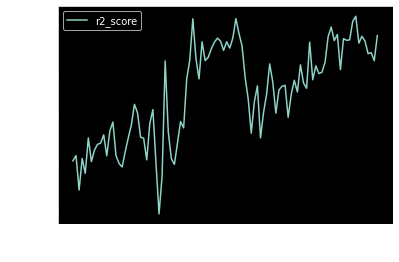

In [66]:
plt.plot(trainer.epoch_losses[-100:], label=metric.__name__)
    
plt.xlabel("Epoch")
plt.ylabel(metric.__name__)
plt.legend();

In [49]:
# plt.plot(trainer.epoch_losses[-500:], label=f"MSE")
    
# plt.xlabel("Epoch")
# plt.ylabel("Mean Square Error")
# plt.legend();

In [73]:
# Save model

MODEL_PATH = 'saved_models/fm_assets_10K_144_embeddings_quad_root.pt'

# torch.save(trainer.model.state_dict(), MODEL_PATH)

# trainer.model.state_dict()

In [15]:
dataset.target.mean()

0.01

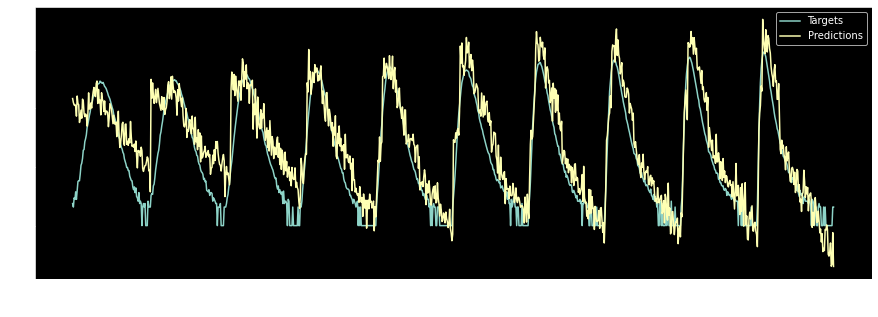

In [69]:
# Predict

indices = list(range(1000))
   
targets, predictions = zip(*map(trainer.predict_by_index, indices))


# Plot

figure = plt.gcf()
figure.set_size_inches(15, 5)

plt.plot(targets, label=f"Targets")
plt.plot(predictions, label=f"Predictions");

plt.xlabel("Sample Number")
plt.ylabel("Probability")
plt.legend()

plt.show()

In [71]:
df = pd.DataFrame({'Targets': targets, 'Predictions': predictions})

# df.to_excel('predictions/10k_predictions_quad_root.xlsx', index=False)

### 7) Assets - 100 Dataset - No Probabilities

In [5]:
# Load Data

# ASSET_DATASET_PATH = 'simulated_prices/asset_prices_10K.csv'

ASSET_DATASET_PATH = 'simulated_prices/assets_no_probabilities_1M_samples.csv'


scheme = {'initial_asset_price': 
              {'binary': True,
               'encoding_format': '>f', 
               'bits_count': 32,
               'factor': .1,
               'target_column': False},
          'volatility': 
              {'binary': True,
               'encoding_format': 'i1', 
               'bits_count': 8,
               'factor': 100,
               'target_column': False},
          'asset_price':
              {'binary': False,
               'factor': .1,
               'target_column': True}}  

dataset = AssetDataset(
    ASSET_DATASET_PATH, 
    chunk_size=100, 
    dataset_size=100,
    scheme=scheme
)

field_dimensions = dataset.field_dimensions

print("dataset.fields.shape:", dataset.fields.shape)
print("dataset.targets.shape:", dataset.target.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions, dataset.field_dimensions.sum())    

Loading: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 364.85chunk/s]

dataset.fields.shape: (100, 40)
dataset.targets.shape: (100, 1)
dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2] 80


In [6]:
splitter = Splitter(dataset, batch_size=100, dataloader_workers_count=8)

trainer = Trainer(splitter=splitter, embedding_dimensions=144)

Split 100: (80, 10, 10)


In [497]:
trainer.fit(epochs=0)


Total - Test mean_squared_error: 0.2475957235


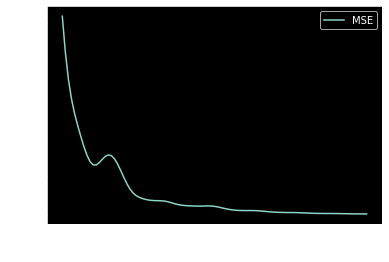

In [9]:
plt.plot(trainer.epoch_losses[:], label=f"MSE")
    
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

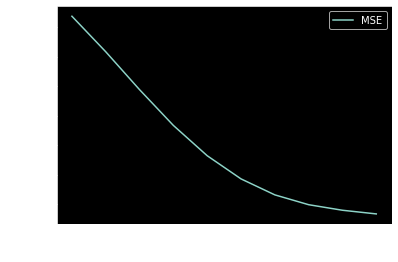

In [10]:
plt.plot(trainer.epoch_losses[-10:], label=f"MSE")
    
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

In [11]:
# Save model

MODEL_PATH = 'saved_models/fm_assets_1K_16_embeddings.pt'

# torch.save(trainer.model.state_dict(), MODEL_PATH)

# trainer.model.state_dict()

In [12]:
# Predict

PREDICTIONS_COUNT = 10

trainer.model.eval()

indices = np.random.randint(0, 100, PREDICTIONS_COUNT)

targets = []
predictions = []

for index in indices:    
    
    row = dataset.data[index]
    fields, target = dataset[index]
    
    decoded_fields = []
    decoded_targets = []

    field_offset = 0

    for column_name, parameters in dataset.scheme.items():

        if parameters['binary']:
            column_size = parameters['bits_count']                
        else:
            column_size = 1

        column = row[field_offset : field_offset + column_size]

        if parameters['binary']:

            decoded_column = dataset.decode_from_bits(column.astype(int),
                                                      dtype=parameters['encoding_format']).item()

        else:                
            decoded_column = column.item()

        if parameters['target_column']:

            decoded_targets.append(decoded_column)

        else:                
            decoded_fields.append(decoded_column)

        field_offset += column_size
    

    # predict

    with torch.no_grad():

        prediction = trainer.model(torch.tensor(fields).int()).item()

    target = decoded_targets[0]
    
    print(f"fields: {decoded_fields}, target: {target:f}, prediction: {prediction:f}")
    
    targets.append(target)
    predictions.append(prediction)

fields: [17.299999237060547, 33], target: 14.950467, prediction: 14.980821
fields: [4.599999904632568, 66], target: 4.022787, prediction: 4.419135
fields: [26.799999237060547, 88], target: 23.148886, prediction: 23.902132
fields: [1.5, 0], target: 1.293718, prediction: 1.021680
fields: [11.0, 100], target: 9.478597, prediction: 9.595205
fields: [20.5, 22], target: 17.680703, prediction: 17.626347
fields: [7.800000190734863, 55], target: 6.758910, prediction: 6.822581
fields: [7.800000190734863, 44], target: 6.758179, prediction: 6.942515
fields: [26.799999237060547, 66], target: 23.156054, prediction: 22.940495
fields: [20.5, 11], target: 17.680231, prediction: 17.863243


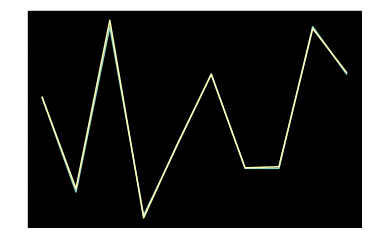

In [13]:
plt.plot(targets)
plt.plot(predictions);

In [605]:
MODEL_PATH = 'saved_models/factorization_machine_100M_144_embeddings.pt'

torch.save(model.state_dict(), MODEL_PATH)

NameError: name 'model' is not defined

In [ ]:
# Load Data

dataset = ChunkDataset(
    REVERSED_OPTION_PROBABILITIES_PATH,
    # OPTION_PROBABILITIES_PATH, 
    dataset_size=1000000,
)

field_dimensions = dataset.field_dimensions

print("dataset.fields.shape:", dataset.fields.shape)
print("dataset.targets.shape:", dataset.targets.shape) 
print("dataset.field_dimensions:", dataset.field_dimensions, dataset.field_dimensions.sum())    

Loading: 100%|██████████████████████████████████████████████████████| 10201/10201 [00:55<00:00, 185.36chunk/s]

dataset.fields.shape: (102010000, 72)
dataset.targets.shape: (102010000,)
dataset.field_dimensions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 144


In [ ]:
splitter = Splitter(dataset, batch_size=1000, dataloader_workers_count=8)

dataset_indices.shape: (102010000,)
dataset_indices: [        0         1         2 ... 102009997 102009998 102009999] int64
dataset_indices: [39404751 33074587 28512073 ... 29626845 39104549 12665155] int64
[39404751 33074587 28512073 ... 65287990 51979360 23205434] [ 4091019 26345064 58833450 ... 89453440 14510084 59233113] [22741452 16869266 38587347 ... 29626845 39104549 12665155]
81608000 10201000 10201000 102010000


In [ ]:
# MODEL_PATH = 'saved_models/factorization_machine_100M.pt'

# loaded_model = CustomFactorizationMachine(field_dimensions, embedding_dimension=embedding_dimension)

# state_dict = torch.load(MODEL_PATH)
# loaded_model.load_state_dict(state_dict)
# loaded_model.eval()

In [14]:
def encode_to_bits(inputs, dtype='>f', bits_count=32):

    number_bytes = np.array([inputs], dtype=dtype)

    integer_view = number_bytes.view('uint8')

    bits_vector = np.unpackbits(integer_view)

    bits = bits_vector.reshape(-1, bits_count)

    return bits


def decode_from_bits(bits, dtype='>f', bitorder='big'):
    
    bits_vector = bits.reshape(-1)
    
    integer_view = np.packbits(bits_vector, bitorder=bitorder)

    output = integer_view.view(dtype)
    
    return output

In [15]:
for fields_batch, target_batch in splitter.test_data_loader:
   
    for fields, target in zip(fields_batch[:10], target_batch[:10]):
        
        intial_option_price_bits = fields[:32].numpy()
        volatility_bits = fields[32:32 + 8].numpy()

        intial_option_price = decode_from_bits(intial_option_price_bits)
        volatility = decode_from_bits(volatility_bits, dtype='i1')

        print(intial_option_price_bits, volatility_bits, intial_option_price, volatility)
        
    break

[0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 0 0] [4600.] [8]
[0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 1 1 1] [9300.] [7]
[0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 1 1 1 1 1] [10000.] [63]
[0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 0 1 0] [2700.] [66]
[0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 1 1 0 0] [4200.] [76]
[0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 1 0 0 0] [2100.] [72]
[0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 1 0 1 0 1] [1400.] [85]
[0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 1 0 1 0] [1500.] [42]
[0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 1 0 1 1] [5700.] [43]
[0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0] [6200.] [0]


In [17]:
model.eval()
    
targets = []
predictions = []
fields_list = []

with torch.no_grad():

    for fields, target in trainer.splitter.test_data_loader:
        
        prediction = model(fields.int())

        targets.extend(target.tolist())
        predictions.extend(prediction.tolist())
        fields_list.extend(fields)
        
        break
        
for fields, target, prediction in list(zip(fields_list, targets, predictions))[:10]:

    intial_stock_price_bits = fields[:32]
    volatility_bits = fields[32 : 32 + 8]
    option_price_bits = fields[32 + 8 : 32 + 8 + 32]
    
    intial_stock_price = decode_from_bits(intial_stock_price_bits)
    volatility = decode_from_bits(volatility_bits, dtype='i1')
    option_price = decode_from_bits(option_price_bits)
    
    print(intial_stock_price, volatility, option_price, target, prediction)

[4600.] [8] [4124.875] 0.0002 -0.009663581848144531
[9300.] [7] [7468.6055] 0.0004 -0.01102834939956665
[10000.] [63] [31947.064] 0.0 -0.026633262634277344
[2700.] [66] [145.7075] 0.001 0.01563405990600586
[4200.] [76] [13736.384] 0.0001 -0.019412517547607422
[2100.] [72] [10532.518] 0.0 -0.00978231430053711
[1400.] [85] [22192.334] 0.0 -0.01628589630126953
[1500.] [42] [1476.3826] 0.0001 -0.012578964233398438
[5700.] [43] [14892.671] 0.0 -0.026964664459228516
[6200.] [0] [4917.28] 0.0 -0.015668869018554688


### Tiny Dataset

In [15]:
# Factorization Machine (FM):

# initial_stock_price, volatility, option_price -> probability

# QUBO:
    
# initial_stock_price, volatility -> maximize probability -> probability


TINY_DATASET = np.array([
    
    [0, 0, 0.0],
    [0, 1, 1.0],
    
    [1, 0, 0.0],
    [1, 1, 1.0],
    
    [2, 0, 0.1],
    [2, 1, 0.9],
    
    [3, 0, 0.1],
    [3, 1, 0.9],
    [4, 0, 0.2],
    [4, 1, 0.8],    
    [5, 0, 0.2],
    [5, 1, 0.8],    
    [6, 0, 0.3],
    [6, 1, 0.7],
    [7, 0, 0.3],
    [7, 1, 0.7],
    
    [8, 0, 0.4],
    [8, 1, 0.6],
    [9, 0, 0.4],
    [9, 1, 0.6],
    [10, 0, 0.5],
    [10, 1, 0.5],
    [11, 0, 0.5],
    [11, 1, 0.5],
    [12, 0, 0.6],
    [12, 1, 0.4],    
    [13, 0, 0.6],
    [13, 1, 0.4],    
    [14, 0, 0.7],
    [14, 1, 0.3],
    [15, 0, 0.7],
    [15, 1, 0.3],
])

In [16]:
REVERSED_TINY_DATASET = TINY_DATASET.copy()

REVERSED_TINY_DATASET[:, 0] = REVERSED_TINY_DATASET[:, 0][::-1]

In [17]:
class TinyDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):

        prices = dataset[:, 0]
        labels = dataset[:, 1]
        
        self.targets = dataset[:, 2]
        
        encoded_price_bytes = self.encode_to_bits(prices, dtype='>i1', bits_count=8)
        encoded_label_bytes = self.encode_to_bits(labels, dtype='>i1', bits_count=8)
        
        encoded_prices = encoded_price_bytes[:, -4:]
        encoded_labels = encoded_label_bytes[:, -1:]

        self.fields = np.hstack((encoded_prices, encoded_labels))
        
        self.field_dimensions = 2 * np.ones(self.fields.shape[1], dtype=int)

        # print("encoded_prices:", encoded_prices)
        # print("labels:", labels)
        # print("encoded_labels:", encoded_labels)
        # print("self.fields:", self.fields)        
        # print("self.targets:", self.targets)
        # print("self.field_dimensions:", self.field_dimensions)    
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.targets[index]
        
        # print("index:", index)
        # print("fields:", fields)       
        # print("target:", target)
        
        return fields, target
    

    def encode_to_bits(self, inputs, dtype='>f', bits_count=32):
    
        number_bytes = np.array([inputs], dtype=dtype)

        integer_view = number_bytes.view('uint8')

        bits_vector = np.unpackbits(integer_view)
        
        bits = bits_vector.reshape(-1, bits_count)

        return bits

In [19]:
tiny_dataset = TinyDataset(TINY_DATASET)

In [20]:
splitter = Splitter(tiny_dataset, batch_size=1, dataloader_workers_count=1)

Split 32: (25, 3, 4)


In [25]:
trainer = Trainer(splitter=splitter)

In [29]:
trainer.fit(epochs=1)

Epoch: 1/1: 100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 202.75 batches/s, loss=3.22]


Validation mean_squared_error: 10.39744, Duration: 0.15 seconds

Total - Test mean_squared_error: 7.8695274532


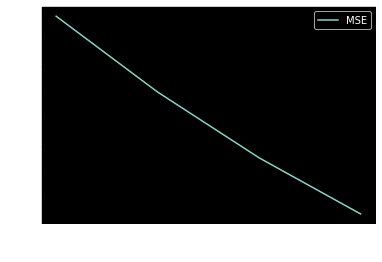

In [30]:
plt.plot(trainer.scores, label="MSE")
    
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend();

In [31]:
TINY_MODEL_PATH = 'saved_models/reversed_tiny_model.pt'

# torch.save(model.state_dict(), TINY_MODEL_PATH)

In [33]:
model.state_dict()

OrderedDict([('embedding.embedding.weight',
              tensor([[-0.2780,  0.1157, -0.1631,  0.1593,  0.2607,  0.1061, -0.0157, -0.2719,
                       -0.0752,  0.4584,  0.3653, -0.0233,  0.0166, -0.1524,  0.1108,  0.4640],
                      [ 0.4547,  0.1793, -0.1813,  0.2707,  0.1178,  0.2580,  0.4135,  0.4491,
                       -0.1459,  0.3724, -0.3251, -0.3532,  0.4135,  0.1947, -0.1313, -0.1612],
                      [ 0.4905, -0.2635, -0.1443, -0.1841, -0.2641, -0.1034, -0.1186, -0.4277,
                       -0.4560, -0.1797, -0.3060, -0.0227, -0.4088,  0.0531, -0.3327, -0.0497],
                      [ 0.2959,  0.1894, -0.3506,  0.2687,  0.3811,  0.0623, -0.3156,  0.3348,
                       -0.4323, -0.3980, -0.4259,  0.1165, -0.3869, -0.0956,  0.2425,  0.1070],
                      [ 0.4915, -0.3454, -0.2853,  0.1523, -0.2245, -0.0654, -0.4646, -0.1426,
                       -0.1933,  0.2994, -0.0954,  0.4102, -0.4979, -0.0879,  0.1931,  0.2750],
 

In [ ]:
class OldAssetDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, chunk_size, dataset_size, probability_factor=1,
                 binary=True, scheme=None):
        
        # Scheme
        
        default_scheme = {'target_column': 'probability',
                          'field_columns':
                              {'initial_asset_price': ('>f', 32),
                               'volatility': ('>i1', 8),
                               'asset_price': ('>f', 32)}}                          
        
        scheme = default_scheme if scheme is None else scheme

        target_column = scheme['target_column']
        fields_scheme = scheme['field_columns']
        
        
        # Data

        chunks_count = dataset_size // chunk_size        
              
        dataset_iterator = pd.read_csv(dataset_path, iterator=True, chunksize=chunk_size)
        
        chunk_tracker = tqdm.tqdm(range(chunks_count),
                                  desc=f"Loading",
                                  ncols=110,
                                  unit='chunk',
                                  total=chunks_count)                          
        # Loading
        
        if binary:            
            fields_count = sum(bit_count for encoding_format, bit_count in fields_scheme.values())
            fields_dtype = 'int64'
        else:            
            fields_count = len(scheme)
            fields_dtype = float
        
        self.fields = np.zeros(shape=(dataset_size, fields_count), dtype=fields_dtype)
        self.targets = np.zeros(shape=dataset_size)
        
        row_offset = 0

        for chunk_index in chunk_tracker:
            
            chunk = next(dataset_iterator)

            column_offset = 0

            for column_name, (encoding_format, column_size) in fields_scheme.items():
                
                if column_name == 'volatility':                    
                    chunk[column_name] = 100 * chunk[column_name]

                if binary:
                    column = self.encode_to_bits(chunk[column_name], 
                                                 dtype=encoding_format, 
                                                 bits_count=column_size)                        
                else:                        
                    column = chunk[column_name].to_numpy().reshape(-1, 1)                        
                    column_size = 1                        

                self.fields[row_offset : row_offset + chunk_size, 
                            column_offset : column_offset + column_size] = column

                column_offset += column_size
                
            self.targets[row_offset : row_offset + chunk_size] = probability_factor * chunk[target_column]

            row_offset += chunk_size
        
        self.field_dimensions = 2 * np.ones(self.fields.shape[1], dtype=int)
        
        print(self.fields[100])
        
        
    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.targets[index]

        return fields, target
    

    def encode_to_bits(self, inputs, dtype='>f', bits_count=32):
    
        number_bytes = np.array([inputs], dtype=dtype)

        integer_view = number_bytes.view('uint8')

        bits_vector = np.unpackbits(integer_view)
        
        bits = bits_vector.reshape(-1, bits_count)

        return bits
    

    def decode_from_bits(self, bits, dtype='>f', bitorder='big'):

        bits_vector = bits.reshape(-1)

        integer_view = np.packbits(bits_vector, bitorder=bitorder)

        output = integer_view.view(dtype)

        return output